In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow import keras
### hack tf-keras to appear as top level keras
import sys
sys.modules['keras'] = keras
### end of hack

import keras.backend as K
from keras.utils import multi_gpu_model
from keras.callbacks import TensorBoard

from sklearn.model_selection import KFold

import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from keras.callbacks import *
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pprint
import os
from os import listdir
from os.path import isfile, join
from datetime import datetime
from sklearn.metrics import confusion_matrix

from keras.utils import plot_model
import matplotlib.pyplot as plt

# Importing custom framework
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
from data_split import prepare_data_waveform, plot_confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [2]:
def build_cnn():
    #conv3-100,maxpool2, conv3-64, maxpool2, conv3-128, maxpool2, conv3-128,maxpool2,  conv3-128,  
    #maxpool2,  conv3-128,  maxpool2,  FC-1024FC-512, FC-10
    
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape=(8000, 1)),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [3]:
waveformPath = '../../merged/waveform.hdf5'
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_waveform(waveformPath)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[2], X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

In [4]:
import gc
gc.collect()
K.clear_session()
tf.compat.v1.reset_default_graph()
X_train.shape

(18000, 8000, 1)

In [5]:
#tf.reset_default_graph()

tbCallBack = TensorBoard(log_dir='logs', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         write_images=True)


# Experiment 1 (AudioNet)

In [6]:
model = build_cnn()
plot_model(model, to_file='CNN_Experiment1.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [7]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = SGD(lr=0.001, momentum=0.9, clipvalue=5)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/200
  1/180 [..............................] - ETA: 0s - loss: 2.3132 - accuracy: 0.1200WARNING:tensorflow:From /home/carl/anaconda3/envs/xai_model_explanation/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
180/180 [==============================] - 202s 1s/step - loss: 2.2827 - accuracy: 0.1242 - val_loss: 2.2488 - val_accuracy: 0.1323
Epoch 2/200
180/180 [==============================] - 201s 1s/step - loss: 2.1852 - accuracy: 0.1768 - val_loss: 2.0965 - val_accuracy: 0.2625
Epoch 3/200
180/180 [==============================] - 201s 1s/step - loss: 2.0320 - accuracy: 0.2662 - val_loss: 1.9377 - val_accuracy: 0.3268
Epoch 4/200
180/180 [==============================] - 202s 1s/step - loss: 1.9046 - accuracy: 0.3076 - val_loss: 1.8470 - val_accuracy: 0.3260
Epoch 5/200
180/180 [====

Epoch 55/200
180/180 [==============================] - 200s 1s/step - loss: 0.1648 - accuracy: 0.9348 - val_loss: 0.4687 - val_accuracy: 0.8525
Epoch 56/200
180/180 [==============================] - 200s 1s/step - loss: 0.1633 - accuracy: 0.9355 - val_loss: 0.4768 - val_accuracy: 0.8473
Epoch 57/200
180/180 [==============================] - 200s 1s/step - loss: 0.1546 - accuracy: 0.9395 - val_loss: 0.4630 - val_accuracy: 0.8525
Epoch 58/200
180/180 [==============================] - 201s 1s/step - loss: 0.1575 - accuracy: 0.9397 - val_loss: 0.4732 - val_accuracy: 0.8495
Epoch 59/200
180/180 [==============================] - 201s 1s/step - loss: 0.1554 - accuracy: 0.9392 - val_loss: 0.4870 - val_accuracy: 0.8492
Epoch 60/200
180/180 [==============================] - 201s 1s/step - loss: 0.1427 - accuracy: 0.9445 - val_loss: 0.4716 - val_accuracy: 0.8567
Epoch 61/200
180/180 [==============================] - 201s 1s/step - loss: 0.1396 - accuracy: 0.9452 - val_loss: 0.4600 - val_ac

180/180 [==============================] - 201s 1s/step - loss: 0.0252 - accuracy: 0.9912 - val_loss: 0.5858 - val_accuracy: 0.8643
Epoch 112/200
180/180 [==============================] - 201s 1s/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.5418 - val_accuracy: 0.8768
Epoch 113/200
180/180 [==============================] - 201s 1s/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.5413 - val_accuracy: 0.8792
Epoch 114/200
180/180 [==============================] - 201s 1s/step - loss: 0.0244 - accuracy: 0.9929 - val_loss: 0.5562 - val_accuracy: 0.8780
Epoch 115/200
180/180 [==============================] - 201s 1s/step - loss: 0.0205 - accuracy: 0.9931 - val_loss: 0.5471 - val_accuracy: 0.8762
Epoch 116/200
180/180 [==============================] - 201s 1s/step - loss: 0.0200 - accuracy: 0.9933 - val_loss: 0.5482 - val_accuracy: 0.8767
Epoch 117/200
180/180 [==============================] - 201s 1s/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.5810 - val_accuracy:

180/180 [==============================] - 202s 1s/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.5651 - val_accuracy: 0.8908
Epoch 168/200
180/180 [==============================] - 202s 1s/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.5822 - val_accuracy: 0.8898
Epoch 169/200
180/180 [==============================] - 202s 1s/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.5793 - val_accuracy: 0.8897
Epoch 170/200
180/180 [==============================] - 202s 1s/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.5826 - val_accuracy: 0.8885
Epoch 171/200
180/180 [==============================] - 202s 1s/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.5728 - val_accuracy: 0.8930
Epoch 172/200
180/180 [==============================] - 202s 1s/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.5819 - val_accuracy: 0.8857
Epoch 173/200
180/180 [==============================] - 202s 1s/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.5599 - val_accuracy:

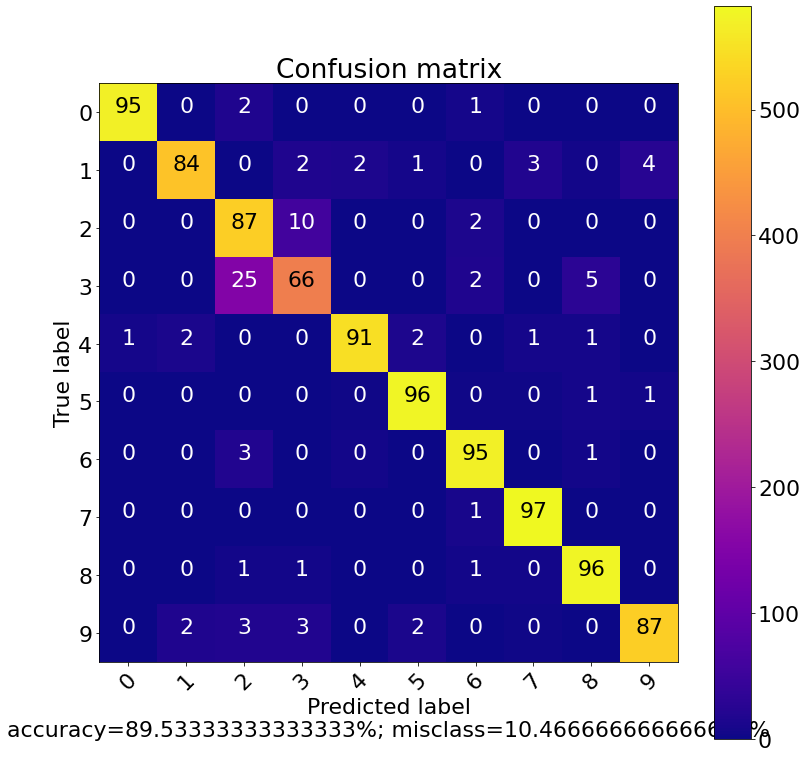

In [8]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [9]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.6097144484519958, 0.909500002861023]


# Experiment 2

In [10]:
model = build_cnn()
#plot_model(model, to_file='CNN_Experiment2.png', show_shapes=True, show_layer_names=True)

In [11]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/200
180/180 [==============================] - 201s 1s/step - loss: 1.5548 - accuracy: 0.4312 - val_loss: 2.1675 - val_accuracy: 0.3887
Epoch 2/200
180/180 [==============================] - 201s 1s/step - loss: 0.8624 - accuracy: 0.6962 - val_loss: 1.8461 - val_accuracy: 0.5468
Epoch 3/200
180/180 [==============================] - 201s 1s/step - loss: 0.5166 - accuracy: 0.8098 - val_loss: 0.6954 - val_accuracy: 0.7938
Epoch 4/200
180/180 [==============================] - 201s 1s/step - loss: 0.4070 - accuracy: 0.8636 - val_loss: 0.5780 - val_accuracy: 0.8402
Epoch 5/200
180/180 [==============================] - 202s 1s/step - loss: 0.2853 - accuracy: 0.9023 - val_loss: 0.5401 - val_accuracy: 0.8757
Epoch 6/200
180/180 [==============================] - 201s 1s/step - loss: 0.2117 - accuracy: 0.9272 - val_loss: 0.3864 - val_accuracy: 0.8975
Epoch 7/200
180/180 [==============================] - 201s 1s/step - loss: 0.1600 - accuracy: 0.9446 - val_loss: 0.4328 - val_accuracy:

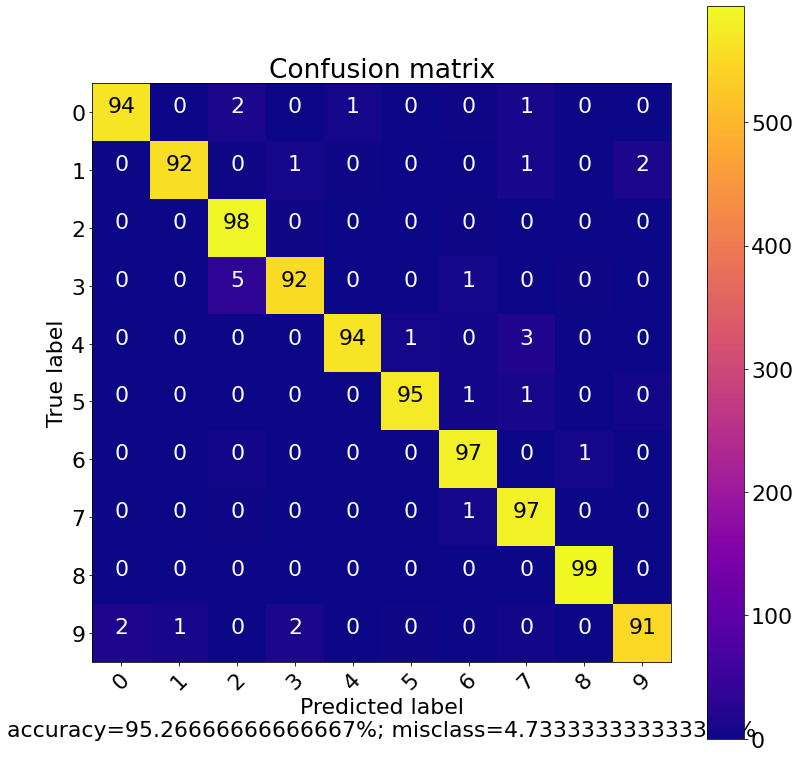

In [12]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [13]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.4113892912864685, 0.9396666884422302]


# Experiment 3

In [14]:
model = keras.models.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape=(8000, 1)),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [15]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/200
180/180 [==============================] - 198s 1s/step - loss: 1.9712 - accuracy: 0.2382 - val_loss: 2.2656 - val_accuracy: 0.2298
Epoch 2/200
180/180 [==============================] - 196s 1s/step - loss: 1.5808 - accuracy: 0.3606 - val_loss: 1.7817 - val_accuracy: 0.2868
Epoch 3/200
180/180 [==============================] - 197s 1s/step - loss: 1.3597 - accuracy: 0.4293 - val_loss: 1.8008 - val_accuracy: 0.4000
Epoch 4/200
180/180 [==============================] - 197s 1s/step - loss: 1.0756 - accuracy: 0.5791 - val_loss: 1.6238 - val_accuracy: 0.5630
Epoch 5/200
180/180 [==============================] - 196s 1s/step - loss: 0.7054 - accuracy: 0.7462 - val_loss: 1.6266 - val_accuracy: 0.6988
Epoch 6/200
180/180 [==============================] - 196s 1s/step - loss: 0.5231 - accuracy: 0.8210 - val_loss: 0.7793 - val_accuracy: 0.8043
Epoch 7/200
180/180 [==============================] - 197s 1s/step - loss: 0.4265 - accuracy: 0.8654 - val_loss: 0.6120 - val_accuracy:

180/180 [==============================] - 198s 1s/step - loss: 0.0192 - accuracy: 0.9951 - val_loss: 0.2656 - val_accuracy: 0.9520
Epoch 58/200
180/180 [==============================] - 198s 1s/step - loss: 0.0221 - accuracy: 0.9952 - val_loss: 0.2095 - val_accuracy: 0.9567
Epoch 59/200
180/180 [==============================] - 198s 1s/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 0.2400 - val_accuracy: 0.9575
Epoch 60/200
180/180 [==============================] - 198s 1s/step - loss: 0.0095 - accuracy: 0.9984 - val_loss: 0.1960 - val_accuracy: 0.9627
Epoch 61/200
180/180 [==============================] - 198s 1s/step - loss: 0.0094 - accuracy: 0.9981 - val_loss: 0.1821 - val_accuracy: 0.9662
Epoch 62/200
180/180 [==============================] - 198s 1s/step - loss: 0.0091 - accuracy: 0.9978 - val_loss: 0.2441 - val_accuracy: 0.9582
Epoch 63/200
180/180 [==============================] - 198s 1s/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.2971 - val_accuracy: 0.958

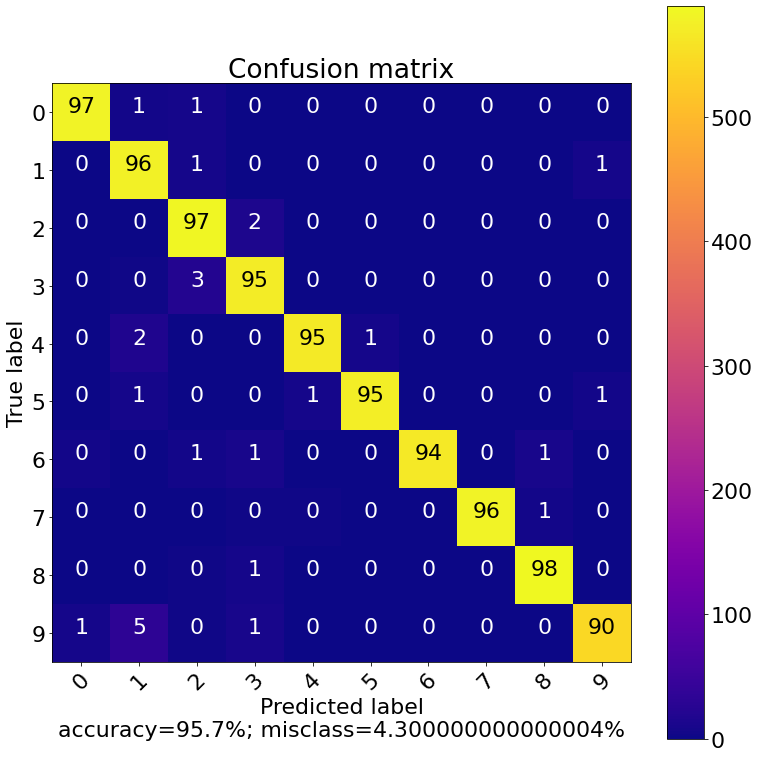

In [16]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [17]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.5476766228675842, 0.9599999785423279]


# Experiment 4

In [18]:
model = keras.models.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape=(8000, 1)),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
#plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)

In [19]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
180/180 [==============================] - 197s 1s/step - loss: 2.1610 - accuracy: 0.1818 - val_loss: 1.9383 - val_accuracy: 0.3088
Epoch 2/100
180/180 [==============================] - 196s 1s/step - loss: 1.6483 - accuracy: 0.3818 - val_loss: 1.4836 - val_accuracy: 0.4707
Epoch 3/100
180/180 [==============================] - 197s 1s/step - loss: 1.1277 - accuracy: 0.5824 - val_loss: 1.0342 - val_accuracy: 0.6417
Epoch 4/100
180/180 [==============================] - 198s 1s/step - loss: 0.7473 - accuracy: 0.7233 - val_loss: 0.5824 - val_accuracy: 0.7878
Epoch 5/100
180/180 [==============================] - 198s 1s/step - loss: 0.5993 - accuracy: 0.7796 - val_loss: 0.4490 - val_accuracy: 0.8405
Epoch 6/100
180/180 [==============================] - 198s 1s/step - loss: 0.4812 - accuracy: 0.8302 - val_loss: 0.3937 - val_accuracy: 0.8700
Epoch 7/100
180/180 [==============================] - 198s 1s/step - loss: 0.3776 - accuracy: 0.8682 - val_loss: 0.3657 - val_accuracy:

180/180 [==============================] - 199s 1s/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.1686 - val_accuracy: 0.9660
Epoch 58/100
180/180 [==============================] - 199s 1s/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.3101 - val_accuracy: 0.9435
Epoch 59/100
180/180 [==============================] - 199s 1s/step - loss: 0.0069 - accuracy: 0.9976 - val_loss: 0.2233 - val_accuracy: 0.9578
Epoch 60/100
180/180 [==============================] - 199s 1s/step - loss: 0.0059 - accuracy: 0.9977 - val_loss: 0.1299 - val_accuracy: 0.9678
Epoch 61/100
180/180 [==============================] - 199s 1s/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.2126 - val_accuracy: 0.9510
Epoch 62/100
180/180 [==============================] - 199s 1s/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.1582 - val_accuracy: 0.9608
Epoch 63/100
180/180 [==============================] - 199s 1s/step - loss: 0.0160 - accuracy: 0.9957 - val_loss: 0.2045 - val_accuracy: 0.947

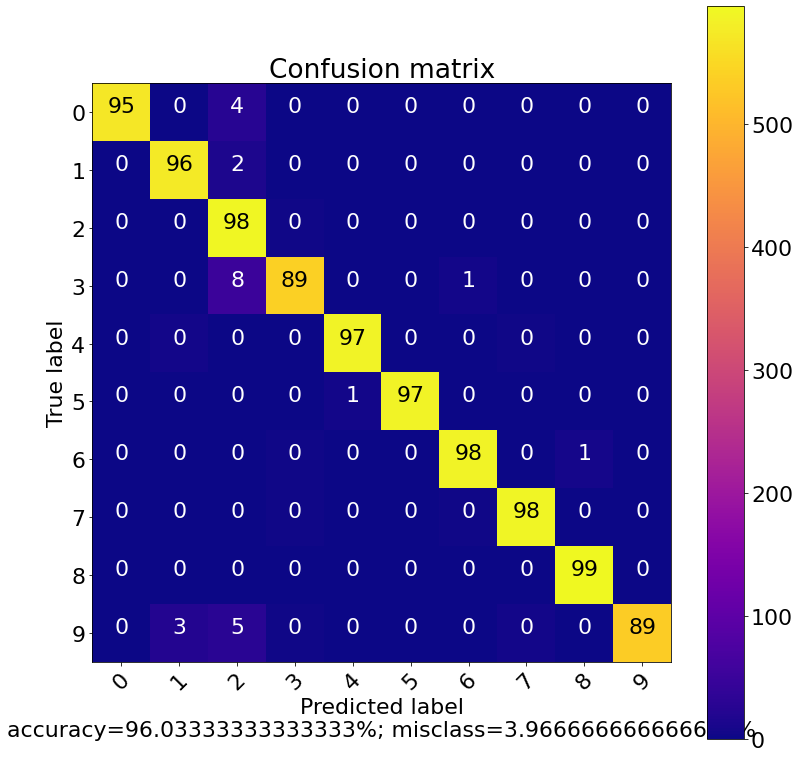

In [20]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [21]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.23813584446907043, 0.9593333601951599]


# Experiment 5

In [22]:
model = keras.models.Sequential([
        keras.layers.Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape=(8000, 1)),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding="same"),
        keras.layers.MaxPool1D(pool_size=2, strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
#plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)

In [23]:
K.clear_session()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
opt = Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=100, callbacks=[earlyStopping, tbCallBack], shuffle=False)
    
val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
180/180 [==============================] - 199s 1s/step - loss: 2.2886 - accuracy: 0.1097 - val_loss: 2.2706 - val_accuracy: 0.1212
Epoch 2/100
180/180 [==============================] - 198s 1s/step - loss: 2.2391 - accuracy: 0.1232 - val_loss: 2.1960 - val_accuracy: 0.1548
Epoch 3/100
180/180 [==============================] - 198s 1s/step - loss: 2.1812 - accuracy: 0.1553 - val_loss: 2.1125 - val_accuracy: 0.2495
Epoch 4/100
180/180 [==============================] - 199s 1s/step - loss: 2.1100 - accuracy: 0.2129 - val_loss: 2.0203 - val_accuracy: 0.3017
Epoch 5/100
180/180 [==============================] - 198s 1s/step - loss: 2.0302 - accuracy: 0.2660 - val_loss: 1.9250 - val_accuracy: 0.3417
Epoch 6/100
180/180 [==============================] - 198s 1s/step - loss: 1.9472 - accuracy: 0.2987 - val_loss: 1.8463 - val_accuracy: 0.3693
Epoch 7/100
180/180 [==============================] - 198s 1s/step - loss: 1.8737 - accuracy: 0.3292 - val_loss: 1.7528 - val_accuracy:

180/180 [==============================] - 198s 1s/step - loss: 0.3090 - accuracy: 0.8872 - val_loss: 0.4983 - val_accuracy: 0.8335
Epoch 58/100
180/180 [==============================] - 199s 1s/step - loss: 0.3052 - accuracy: 0.8916 - val_loss: 0.5007 - val_accuracy: 0.8363
Epoch 59/100
180/180 [==============================] - 199s 1s/step - loss: 0.2899 - accuracy: 0.8955 - val_loss: 0.4939 - val_accuracy: 0.8367
Epoch 60/100
180/180 [==============================] - 199s 1s/step - loss: 0.2753 - accuracy: 0.9004 - val_loss: 0.4647 - val_accuracy: 0.8430
Epoch 61/100
180/180 [==============================] - 198s 1s/step - loss: 0.2809 - accuracy: 0.8998 - val_loss: 0.4627 - val_accuracy: 0.8488
Epoch 62/100
180/180 [==============================] - 198s 1s/step - loss: 0.2663 - accuracy: 0.9043 - val_loss: 0.4637 - val_accuracy: 0.8482
Epoch 63/100
180/180 [==============================] - 198s 1s/step - loss: 0.2607 - accuracy: 0.9082 - val_loss: 0.4504 - val_accuracy: 0.852

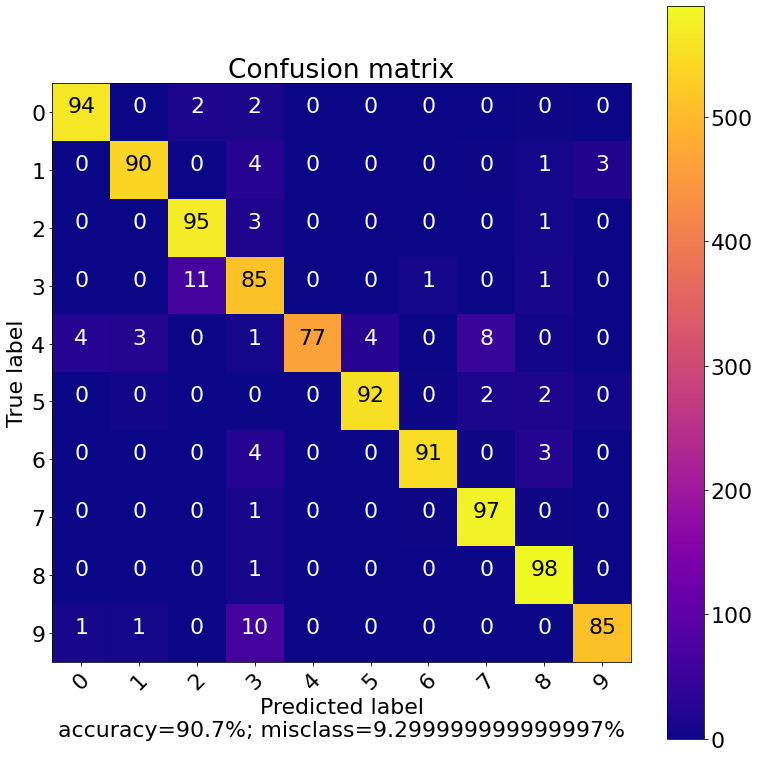

In [24]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [25]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.30101752281188965, 0.92166668176651]
